# Proyecto: Predicción de muertes por covid-19 en Perú y Arequipa

### Librerias utilizadas

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Obtención y Análisis de los Datos


In [59]:
url = 'https://raw.githubusercontent.com/jmcastagnetto/covid-19-peru-data/master/datos/covid-19-peru-data.csv'
full_data = pd.read_csv(url)
full_data.tail()

,country,iso3c,region,date,confirmed,deaths,recovered,negative_cases,pcr_positivo,prueba_rapida_positivo,pcr_prapida_positivo
1548,Peru,PER,San Martín,2020-05-20,822,13.0,NaN,NaN,235.0,587.0,NaN
1549,Peru,PER,Tacna,2020-05-20,242,4.0,NaN,NaN,30.0,212.0,NaN
1550,Peru,PER,Tumbes,2020-05-20,702,62.0,NaN,NaN,75.0,627.0,NaN
1551,Peru,PER,Ucayali,2020-05-20,2371,91.0,NaN,NaN,447.0,1924.0,NaN
1552,Peru,PER,NaN,2020-05-20,104020,3024.0,41968.0,611403.0,29690.0,74330.0,NaN


Revisamos los datos

In [87]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1553 entries, 0 to 1552
Data columns (total 11 columns):
country                   1553 non-null object
iso3c                     1553 non-null object
region                    1478 non-null object
date                      1553 non-null object
confirmed                 1553 non-null int64
deaths                    966 non-null float64
recovered                 93 non-null float64
negative_cases            75 non-null float64
pcr_positivo              1063 non-null float64
prueba_rapida_positivo    1000 non-null float64
pcr_prapida_positivo      24 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 133.5+ KB


In [89]:
full_data.describe()

,confirmed,deaths,recovered,negative_cases,pcr_positivo,prueba_rapida_positivo,pcr_prapida_positivo
count,1553.000000,966.000000,93.000000,75.000000,1063.000000,1000.000000,24.000000
mean,2337.703799,103.630435,6350.946237,164401.613333,1189.493885,2208.594000,34.583333
std,9974.457069,321.254695,9685.906200,190698.522333,3968.068608,8201.409318,72.926358
min,1.000000,1.000000,1.000000,154.000000,1.000000,1.000000,1.000000
25%,18.000000,2.000000,5.000000,8099.500000,16.500000,60.000000,1.750000
50%,132.000000,7.000000,914.000000,77382.000000,75.000000,173.000000,3.000000
75%,549.000000,59.000000,8425.000000,307554.500000,289.000000,628.500000,6.250000
max,104020.000000,3024.000000,41968.000000,611403.000000,29690.000000,74330.000000,231.000000


Separamos los registros que necesitamos, en este caso serán los que estan `NaN` en la columna `region`. Estas filas contienen las cifras de todo el pais.

Luego separamos las columnas con las que trabajaremos.
- Fecha - `date`
- Número de casos confirmados - `confirmed`
- Núemro de muertes - `deaths`

In [7]:
data_peru = full_data.loc[pd.isnull(full_data['region'])]
data_peru = data_peru.drop(['country','iso3c','region','recovered','negative_cases','pcr_positivo','prueba_rapida_positivo','pcr_prapida_positivo'],
                     axis=1)

Separamos los los datos en 3 conjuntos de datos: `date_deaths`, `date_confirmed` y `date_confirmed_deaths`

En los 3 conjuntos `date` sera una variable independiente, en `date_deaths`y `date_confirmed` la otra variable sera la dependiente.
En `date_confirmed_deaths` se tomará también `confirmed` como una variable independiente. Se tomo esta decisión porque la cantidad de muertes puede depender de la cantidad de contagiados, pero no viceversa

In [8]:
date_deaths = data_peru[['date','deaths','confirmed']]
date_confirmed = data_peru[['date','confirmed','deaths']]
date_deaths = date_deaths.drop(['confirmed'],axis=1)
date_confirmed = date_confirmed.drop(['deaths'],axis=1)
date_confirmed_deaths = data_peru[['date','confirmed','deaths']]

Como `date` es considerado Object, lo transformamos en dalor numérico.

* Generamos `new_date` que sera una lista de 1 hasta la cantidad de registros (75 en 2020-05-20).
* Calculamos `mayo_1` que representará donde dividimos el dataset para tener los conjuntos de entrenamiento y de prueba.

In [10]:
date_deaths['date'] = pd.to_datetime(date_deaths['date']).dt.strftime("%Y%m%d").astype(int)
date_confirmed['date'] = pd.to_datetime(date_confirmed['date']).dt.strftime("%Y%m%d").astype(int)
date_confirmed_deaths['date'] = pd.to_datetime(date_confirmed_deaths['date']).dt.strftime("%Y%m%d").astype(int)

new_date = list(range(1,len(date_confirmed_deaths)+1))

raw_DD = date_deaths.values
mayo_1 = np.where(raw_DD[:,0]==20200501)

date_confirmed_deaths.head()

,date,confirmed,deaths
0,20200306,1,NaN
1,20200307,6,NaN
2,20200309,9,NaN
3,20200310,11,NaN
4,20200311,17,NaN


## Adaptación de los datos

Convertimos los dataframes en arreglos de numpy, de números flotantes

In [11]:
raw_DD = date_deaths.values.astype(np.float32)
raw_DD[:,0] = new_date
raw_DC = date_confirmed.values.astype(np.float32)
raw_DC[:,0] = new_date
raw_DCD = date_confirmed_deaths.values.astype(np.float32)
raw_DCD[:,0] = new_date

Como en algunos registros `death` es `NaN` lo convertimos en 0. En este caso, los valores `Nan` significan que en esos días no hubieron muertos, por eso lo cambiamos por 0.

In [13]:
ind = np.where(np.isnan(raw_DD))
raw_DD[ind] = 0

ind = np.where(np.isnan(raw_DCD))
raw_DCD[ind] = 0

Graficamos los datos de `raw_DD` y `raw_DC`. `raw_DCD` no es necesario graficar ya que sus valores deben ser iguales.

Text(0, 0.5, 'Contagiados')

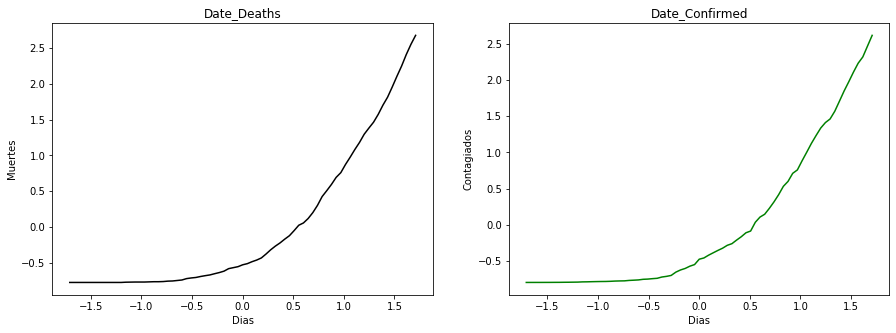

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(raw_DD[:,0],raw_DD[:,1],'black')
ax[0].set_title("Date_Deaths")
ax[0].set_xlabel('Dias')
ax[0].set_ylabel('Muertes')

ax[1].plot(raw_DC[:,0],raw_DC[:,1],'green')
ax[1].set_title("Date_Confirmed")
ax[1].set_xlabel('Dias')
ax[1].set_ylabel('Contagiados')

Graficar la relación entre la cantidad de contagiados y la cantidad de muertos, nos ayuda a confirmar que existe una relación lineal entre estas variables

Text(0.5, 1.0, 'Confirmed_Deaths')

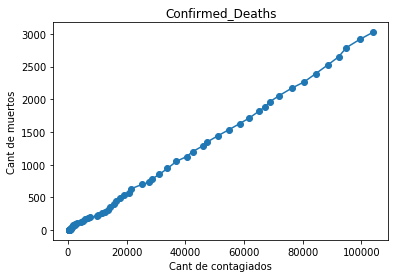

In [92]:
plt.plot(raw_DCD[:,1],raw_DCD[:,2],'-o')
plt.xlabel('Cant de contagiados')
plt.ylabel('Cant de muertos')
plt.title('Confirmed_Deaths')

In [19]:
def Normalizar_Datos( arraynp ):
    mean = np.mean(arraynp,0)
    standard = np.std(arraynp,0)
    print (mean, standard)
    for i in range(0,arraynp.shape[0]):
        arraynp[i] = np.true_divide((arraynp[i] - mean), standard)
    return arraynp

Los arreglos son normalizados

In [20]:
raw_DD = Normalizar_Datos(raw_DD)
raw_DC = Normalizar_Datos(raw_DC)
raw_DCD = Normalizar_Datos(raw_DCD)

[ 38.      679.06665] [ 21.64871 875.40466]
[   38.    24203.467] [2.1648710e+01 3.0525627e+04]
[   38.      24203.467     679.06665] [2.1648710e+01 3.0525627e+04 8.7540466e+02]


La funfión `Adapt_sets` nos permite generar adecuadamente los conjuntos de datos de entrenamiento y prueba

In [18]:
def Adapt_sets(train_set, test_set):
    test_y = test_set[:,-1:]
    test_x = test_set[:,0:-1]
    train_y = train_set[:,-1:]
    train_x = train_set[:,0:-1]
    
    train_x = np.insert(train_x, 0, 1, axis=1)
    test_x = np.insert(test_x, 0, 1, axis=1)
    
    return train_x, train_y, test_x, test_y

* Primero dividimos los arreglos, usando el valor de `mayo_1`. Esto nos permitira entrenar con datos desde 2020-03-06 hasta 2020-04-30
* Luego aplicamos la funcion `Adapt_sets`.

In [21]:
train_set_DD, test_set_DD = np.split(raw_DD,mayo_1[0])
train_set_DC, test_set_DC = np.split(raw_DC,mayo_1[0])
train_set_DCD, test_set_DCD = np.split(raw_DCD,mayo_1[0])

train_DD_x, train_DD_y, test_DD_x, test_DD_y = Adapt_sets(train_set_DD, test_set_DD)
Theta_DD = np.zeros(train_DD_x.shape[1])[np.newaxis]

train_DC_x, train_DC_y, test_DC_x, test_DC_y = Adapt_sets(train_set_DC, test_set_DC)
Theta_DC = np.zeros(train_DC_x.shape[1])[np.newaxis]

train_DCD_x, train_DCD_y, test_DCD_x, test_DCD_y = Adapt_sets(train_set_DCD, test_set_DCD)
Theta_DCD = np.zeros(train_DCD_x.shape[1])[np.newaxis]

## Elaboración del modelo de RL

In [22]:
def Calcular_Costo(X, Y, Theta):
    m = len(X)
    cost = np.sum((X.dot(Theta.T) - Y)**2) / (2 * m)
    return cost

def Gradiente_Descendiente(X, Y, Theta, iteraciones, tasa):
    costos = [0]*iteraciones
    m = len(X)
    for itr in range(iteraciones):
        h = X.dot(Theta.T)
        dif = h - Y
        derivada = (X.T).dot(dif) / m
        Theta = Theta - (tasa * derivada).T
        costos[itr] = Calcular_Costo(X, Y, Theta)
    return Theta, costos

Calculamos nuevos valores para los $ \theta $ con la función `Gradiente_Descendiente` con los parametros:
- iteraciones = 2500
- tasa de entrenamiento = 0.1

In [23]:
newTheta_DD, costos_DD = Gradiente_Descendiente(train_DD_x, train_DD_y, Theta_DD, 2500, 0.1)
newTheta_DC, costos_DC = Gradiente_Descendiente(train_DC_x, train_DC_y, Theta_DC, 2500, 0.1)
newTheta_DCD, costos_DCD = Gradiente_Descendiente(train_DCD_x, train_DCD_y, Theta_DCD, 2500, 0.1)

### Resultados

Graficamos el costo obtenido en cada iteración

Text(0, 0.5, 'Costo')

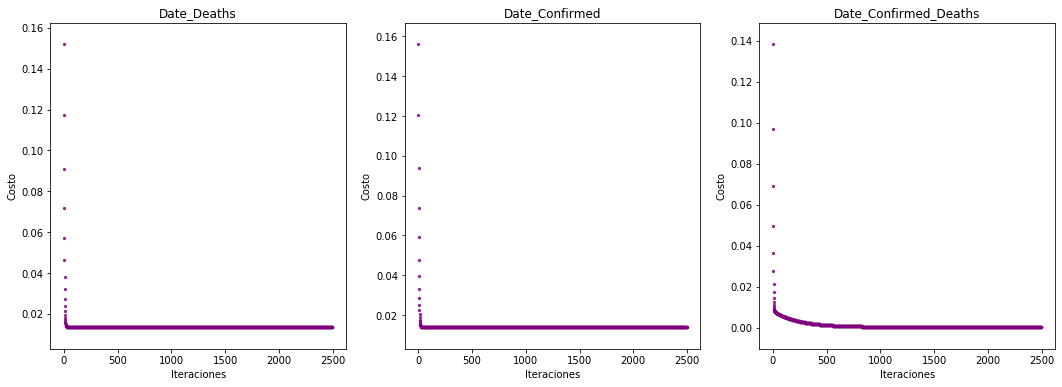

In [24]:
#    Experimento 4
fig, ax = plt.subplots(1, 3, figsize=(18,6))
ax[0].scatter(np.arange(2500), costos_DD, alpha=0.8, c="purple", s=5)
ax[0].set_title("Date_Deaths")
ax[0].set_xlabel('Iteraciones')
ax[0].set_ylabel('Costo')

ax[1].scatter(np.arange(2500), costos_DC, alpha=0.8, c="purple", s=5)
ax[1].set_title("Date_Confirmed")
ax[1].set_xlabel('Iteraciones')
ax[1].set_ylabel('Costo')

ax[2].scatter(np.arange(2500), costos_DCD, alpha=0.8, c="purple", s=5)
ax[2].set_title("Date_Confirmed_Deaths")
ax[2].set_xlabel('Iteraciones')
ax[2].set_ylabel('Costo')

Calculamos los valores que el modelo predice con los conjuntos de prueba

In [25]:
DD_y_predict = test_DD_x.dot(newTheta_DD.T)
DC_y_predict = test_DC_x.dot(newTheta_DC.T)
DCD_y_predict = test_DCD_x.dot(newTheta_DCD.T)

Graficamos las predicciones de los conjuntos de datos que solo usan `date` como variable independiente

Text(0.5, 0, 'Dias')

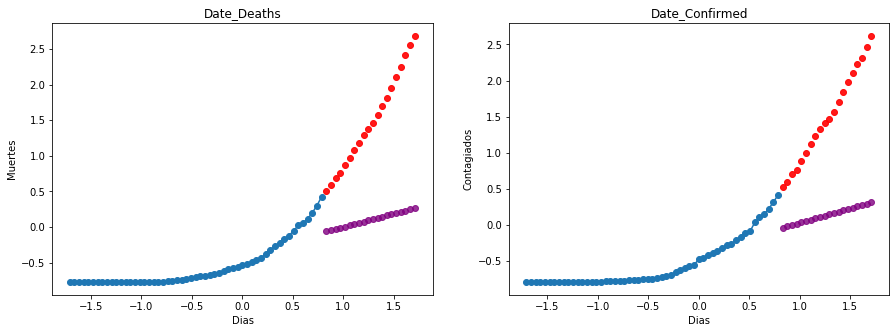

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].scatter(test_DD_x[:,1], test_DD_y, alpha=0.9, c="red")
ax[0].scatter(test_DD_x[:,1], DD_y_predict, alpha=0.8, c="purple")
ax[0].plot(train_DD_x[:,1], train_DD_y, "-o")
ax[0].set_title("Date_Deaths")
ax[0].set_ylabel('Muertes')
ax[0].set_xlabel('Dias')

ax[1].scatter(test_DC_x[:,1], test_DC_y, alpha=0.9, c="red")
ax[1].scatter(test_DC_x[:,1], DC_y_predict, alpha=0.8, c="purple")
ax[1].plot(train_DC_x[:,1], train_DC_y, "-o")
ax[1].set_title("Date_Confirmed")
ax[1].set_ylabel('Contagiados')
ax[1].set_xlabel('Dias')

Graficamos las predicciones del conjunto de datos que usa `date` y `confirmed` como variables independientes

Text(0.5, 0, 'Dias')

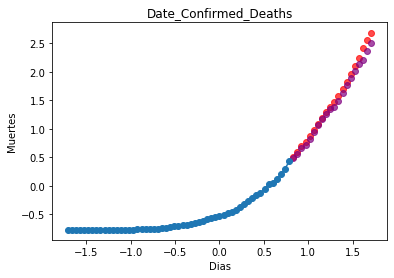

In [96]:
plt.scatter(test_DCD_x[:,1], test_DCD_y, alpha=0.7, c="red")
plt.scatter(test_DCD_x[:,1], DCD_y_predict, alpha=0.7, c="purple")
plt.plot(train_DCD_x[:,1], train_DCD_y, "-o")
plt.title("Date_Confirmed_Deaths")
plt.ylabel('Muertes')
plt.xlabel('Dias')

Para evaluar la eficacia del modelo en el conjunto de prueba, utilizamos las metricas standar `r2 score` `mean squared error` y `root mean squared error`, todas extraidas desde la libreria `sklearn`.

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [35]:
r2_score(test_DCD_y, DCD_y_predict)

0.9799436647525366

In [36]:
mean_squared_error(test_DCD_y, DCD_y_predict)

0.008632560233020066

In [37]:
from math import sqrt
sqrt(mean_squared_error(test_DCD_y, DCD_y_predict))

0.09291157211574921

## Otro enfoque

También podemos buscar predecir la cantidad de muertes por día (la diferencia de casos por dia)

Para eso creamos `O_raw_DCD`, recorremos los datos originales y restamos con el dia anterior

In [43]:
raw_DCD = date_confirmed_deaths.values.astype(np.float32)
raw_DCD[:,0] = new_date

O_raw_DCD = np.zeros(raw_DCD.shape)
O_raw_DCD[0,:] = raw_DCD[0,:]
for i in range(1,len(raw_DCD)):
    O_raw_DCD[i,0] = raw_DCD[i,0]
    O_raw_DCD[i,1] = raw_DCD[i,1] - raw_DCD[i-1,1]
    O_raw_DCD[i,2] = raw_DCD[i,2] - raw_DCD[i-1,2]

Mostramos los nuevos datos obtenidos

Text(0.5, 0, 'Dias')

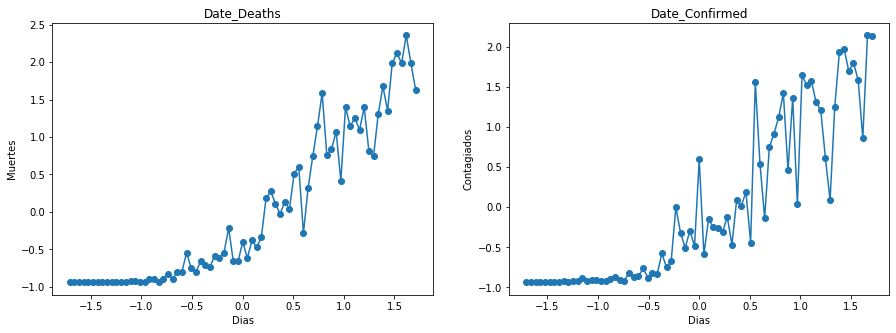

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(O_raw_DCD[:,0], O_raw_DCD[:,2], "-o")
ax[0].set_title("Date_Deaths")
ax[0].set_ylabel('Muertes')
ax[0].set_xlabel('Dias')

ax[1].plot(O_raw_DCD[:,0], O_raw_DCD[:,1], "-o")
ax[1].set_title("Date_Confirmed")
ax[1].set_ylabel('Contagiados')
ax[1].set_xlabel('Dias')

Preparamos lo datos, y calculamos la regresión lineal

In [45]:
ind = np.where(np.isnan(O_raw_DCD))
O_raw_DCD[ind] = 0

O_raw_DCD = Normalizar_Datos(O_raw_DCD)
train_set_DCD, test_set_DCD = np.split(O_raw_DCD,mayo_1[0])

O_train_DCD_x, O_train_DCD_y, O_test_DCD_x, O_test_DCD_y = Adapt_sets(train_set_DCD, test_set_DCD)
O_Theta_DCD = np.zeros(O_train_DCD_x.shape[1])[np.newaxis]


[  38.         1386.93333333   40.28      ] [  21.64871051 1478.13578387   42.73376807]


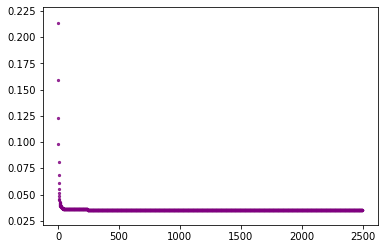

In [46]:
O_newTheta_DCD,O_costos_DCD = Gradiente_Descendiente(O_train_DCD_x, O_train_DCD_y, O_Theta_DCD, 2500, 0.1)
plt.scatter(np.arange(2500), O_costos_DCD, alpha=0.8, c="purple", s=5)

Calculamos las predicciones para el conjunto de pruebas

Text(0, 0.5, 'Nuevas Muertes')

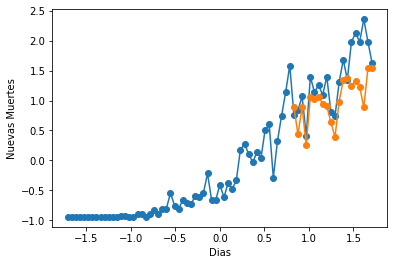

In [57]:
O_DCD_y_predict = O_test_DCD_x.dot(O_newTheta_DCD.T)

plt.plot(O_raw_DCD[:,0], O_raw_DCD[:,-1],'-o')
plt.plot(O_test_DCD_x[:,1],O_DCD_y_predict,'-o')
plt.xlabel('Dias')
plt.ylabel('Nuevas Muertes')

Aplicamos las mismas evaluaciones que al anterior modelo

In [51]:
r2_score(O_test_DCD_y, O_DCD_y_predict)

0.035812306547991835

In [55]:
mean_squared_error(O_test_DCD_y, O_DCD_y_predict)

0.2572474032122964

In [56]:
sqrt(mean_squared_error(O_test_DCD_y, O_DCD_y_predict))

0.5071956261762284



## Arequipa

Para obtener un modelo exclusivo de Arequipa, primero seleccionamos las filas que en `region` sea "Arequipa". Estas filas tienen las cifras de la region Areuipa desde 2020-03-13

In [85]:
data_aqp = full_data.loc[full_data['region'] == 'Arequipa']
data_aqp = data_aqp.drop(['country','iso3c','region','recovered','negative_cases','pcr_positivo','prueba_rapida_positivo','pcr_prapida_positivo'],
                     axis=1)
data_aqp.tail(20)

,date,confirmed,deaths
1036,2020-05-01,624,11.0
1062,2020-05-02,655,16.0
1088,2020-05-03,692,16.0
1114,2020-05-04,692,NaN
1140,2020-05-05,763,18.0
1166,2020-05-06,790,20.0
1192,2020-05-07,814,20.0
1218,2020-05-08,854,20.0
1244,2020-05-09,904,20.0
1270,2020-05-10,1046,20.0


Notamos que el dia 2020-05-04 no se registro fallecidos, siendo imposible que este valor sea 0, tenemos que cambiar la forma de darle valores a `NaN`.

- El primer número de muertos muy posiblemente sea 0.
- Los posteriores `NaN` seran iguales al valor anterior

In [69]:
data_aqp['date'] = pd.to_datetime(data_aqp['date']).dt.strftime("%Y%m%d").astype(int)
raw_AQP = data_aqp.values
mayo_1_aqp = np.where(raw_AQP[:,0]==20200501)

new_date_AQP = list(range(len(raw_AQP)))
raw_AQP[:,0] = new_date_AQP

raw_AQP[0,2] = 0
for i in range(1,len(raw_AQP)):
    if(np.isnan(raw_AQP[i,2])):
        raw_AQP[i,2] = raw_AQP[i-1,2]
raw_AQP = raw_AQP.astype(np.float32)

Graficamos `confirmed` y `deaths` con respecto a los días

Text(0, 0.5, 'Dias')

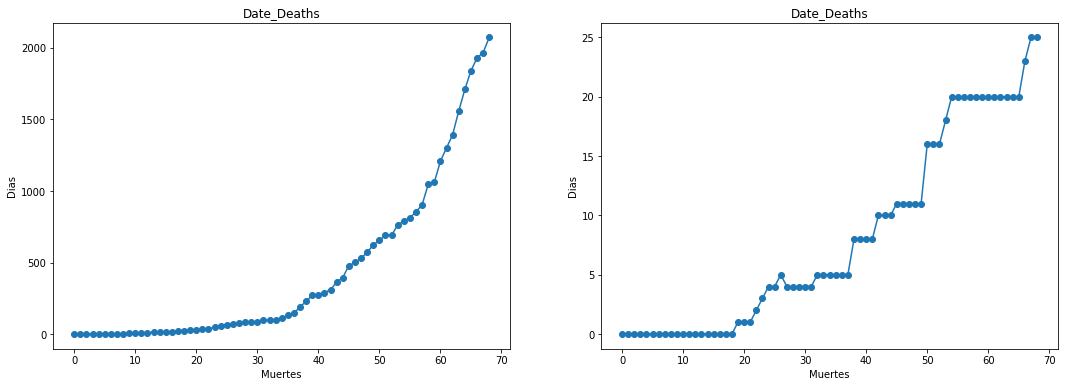

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

ax[0].plot(raw_AQP[:,0], raw_AQP[:,1], "-o")
ax[0].set_title("Date_Confirmed")
ax[0].set_xlabel('Contagiados')
ax[0].set_ylabel('Dias')

ax[1].plot(raw_AQP[:,0], raw_AQP[:,2], "-o")
ax[1].set_title("Date_Deaths")
ax[1].set_xlabel('Muertes')
ax[1].set_ylabel('Dias')

Aplicamos el mismo procedimiento, normalizamos y adquirimos los conjuntos de entrenamiento y prueba

In [71]:
raw_AQP = Normalizar_Datos(raw_AQP)
train_set_AQP, test_set_AQP = np.split(raw_AQP,mayo_1_aqp[0])
print(train_set_AQP.shape, test_set_AQP.shape)
train_AQP_x, train_AQP_y, test_AQP_x, test_AQP_y = Adapt_sets(train_set_AQP, test_set_AQP)
Theta_AQP = np.zeros(train_AQP_x.shape[1])[np.newaxis]

[ 34.       432.56522    8.217391] [ 19.916492 566.3793     8.053929]
(49, 3) (20, 3)


Entrenamos el regresor lineal y graficamos los costos obtenidos

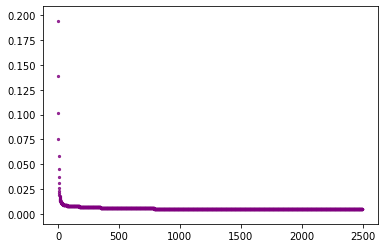

In [72]:
newTheta_AQP, costos_AQP = Gradiente_Descendiente(train_AQP_x, train_AQP_y, Theta_AQP, 2500, 0.1)
plt.scatter(np.arange(2500), costos_AQP, alpha=0.8, c="purple", s=5)

Calculamos las predicciones para el conjunto de pruebas

Text(0, 0.5, 'Nuevas Muertes')

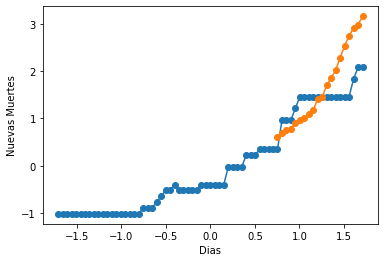

In [73]:
AQP_y_predict = test_AQP_x.dot(newTheta_AQP.T)

plt.plot(raw_AQP[:,0], raw_AQP[:,-1],'-o')
plt.plot(test_AQP_x[:,1],AQP_y_predict,'-o')
plt.xlabel('Dias')
plt.ylabel('Nuevas Muertes')

Evaluamos los resultados con las mismas metricas que a los previos modelos

In [74]:
r2_score(test_AQP_y, AQP_y_predict)

-1.8329686417161541

In [75]:
mean_squared_error(test_AQP_y, AQP_y_predict)

0.4083548385699672

In [76]:
sqrt(mean_squared_error(test_AQP_y, AQP_y_predict))

0.6390264772057315